In [ ]:
import torch
import torch.nn as nn
from util.torch_architecture import CNN

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = CNN()
model.load_state_dict(torch.load("cats_dogs_cnn.pth", map_location=device))
model.to(device)
model.eval()

CNN(
  (model): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (4): Dropout(p=0.25, inplace=False)
    (5): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU()
    (7): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (9): Dropout(p=0.25, inplace=False)
    (10): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU()
    (12): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (13): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (14): Dropout(p=0.25, inplace=False)
    (15): Conv2d(128, 256, kernel_size=(3, 3), stride=

In [ ]:
import os
from PIL import Image
import pandas as pd
from sklearn.model_selection import train_test_split
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms

TRAIN_IMAGES_PATH = 'data/dogs-vs-cats/train'
IMG_SIZE = (128, 128)
BATCH_SIZE = 32

class CatDogDataset(Dataset):
    def __init__(self, dataframe, root_dir, transform=None):
        self.dataframe = dataframe
        self.root_dir = root_dir
        self.transform = transform
        self.class_to_idx = {"dog": 1, "cat": 0}

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, idx):
        img_name = os.path.join(self.root_dir, self.dataframe.iloc[idx]["image"])
        image = Image.open(img_name).convert("RGB")
        label = self.class_to_idx[self.dataframe.iloc[idx]["class"]]

        if self.transform:
            image = self.transform(image)

        return image, torch.tensor(label, dtype=torch.float32)

file_names = os.listdir(TRAIN_IMAGES_PATH)
labels = ["dog" if "dog" in name else "cat" for name in file_names]
df = pd.DataFrame({"image": file_names, "class": labels})

train_df, val_df = train_test_split(df, test_size=0.2, random_state=42)

val_transforms = transforms.Compose([
    transforms.Resize(IMG_SIZE),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5], std=[0.5])
])

val_dataset = CatDogDataset(val_df, TRAIN_IMAGES_PATH, transform=val_transforms)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)

print(f"Validation size: {len(val_dataset)}")


Validation size: 5000


100%|██████████| 1000/1000 [00:04<00:00, 204.52it/s]


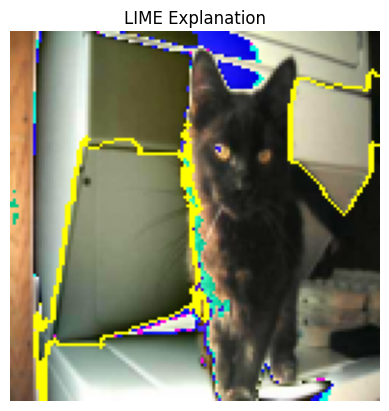

In [ ]:
from lime import lime_image
import numpy as np

def predict_fn(images):
    model.eval()
    images_tensor = torch.stack([transforms.ToTensor()(img).to(device) for img in images])
    outputs = model(images_tensor).detach().cpu().numpy()
    return np.concatenate([1 - outputs, outputs], axis=1)

explainer = lime_image.LimeImageExplainer()

image_to_explain_tensor, _ = val_dataset[0]
image_to_explain_pil = transforms.ToPILImage()(image_to_explain_tensor)

explanation = explainer.explain_instance(
    np.array(image_to_explain_pil),
    predict_fn,
    top_labels=2,
    hide_color=0,
    num_samples=1000
)

from skimage.segmentation import mark_boundaries
import matplotlib.pyplot as plt

temp_image, mask = explanation.get_image_and_mask(
    label=1,
    positive_only=True,
    hide_rest=False,
    num_features=10,
    min_weight=0.05
)

plt.imshow(mark_boundaries(temp_image / 255.0, mask))
plt.title("LIME Explanation")
plt.axis("off")
plt.show()